# Modelo Predictivo de Churn - Telecomunicaciones
## Selección de Features (Ranking Univariado)

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# Cargar dataset
df = pd.read_csv("Dataset-Telco-Customer-Churn.csv")
print(f"Dataset cargado: {df.shape}")
print(f"Distribución Churn: {df['Churn'].value_counts()}")

Dataset cargado: (7043, 21)
Distribución Churn: Churn
No     5174
Yes    1869
Name: count, dtype: int64


In [ ]:
# Preprocesamiento
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
df = df.drop(columns=['customerID'])
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

# Codificación de variables categóricas
df_encoded = df.copy()
for col in df_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])

In [ ]:
# Ranking univariado
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

# Chi2 y Mutual Information
selector_chi2 = SelectKBest(score_func=chi2, k='all')
selector_chi2.fit(X, y)
mi_scores = mutual_info_classif(X, y, random_state=42)

# Tabla de resultados
ranking = pd.DataFrame({
    'Feature': X.columns,
    'Chi2': selector_chi2.scores_,
    'Mutual_Info': mi_scores
}).sort_values(by='Mutual_Info', ascending=False)

print("TOP 10 FEATURES:")
print(ranking.head(10))

TOP 10 FEATURES:
             Feature           Chi2  Mutual_Info
14          Contract    1115.780167     0.091574
4             tenure   16278.923685     0.076971
8     OnlineSecurity     551.611529     0.060872
11       TechSupport     523.303866     0.059060
9       OnlineBackup     230.086520     0.055694
7    InternetService       9.821028     0.054400
16     PaymentMethod      58.492250     0.047912
10  DeviceProtection     191.303140     0.046260
17    MonthlyCharges    3680.787699     0.045334
18      TotalCharges  627340.305176     0.043115


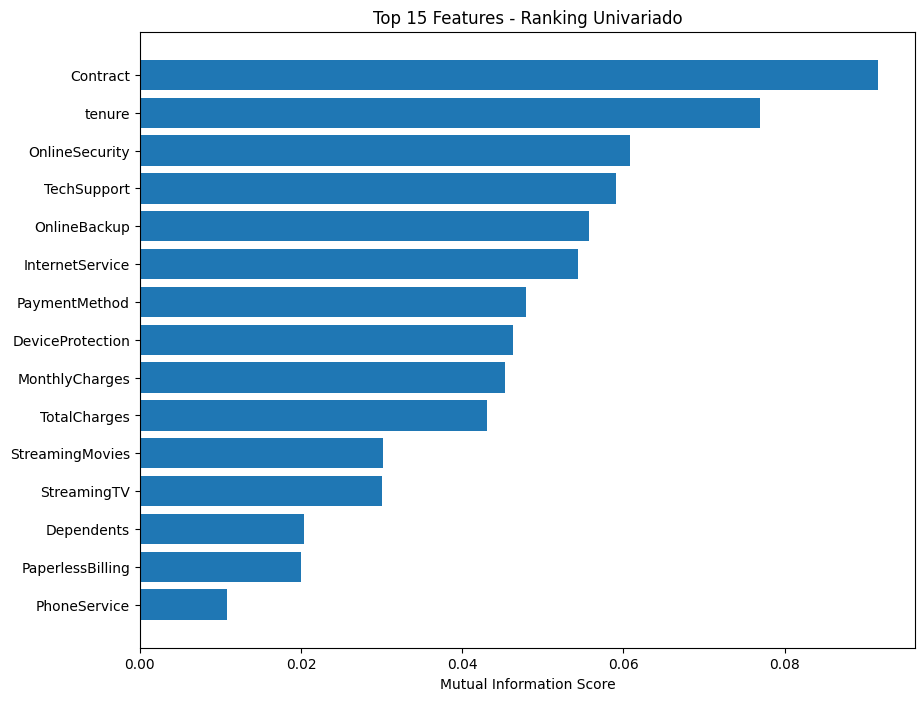

In [ ]:
plt.figure(figsize=(10, 8))
top_features = ranking.head(15)
plt.barh(range(len(top_features)), top_features['Mutual_Info'])
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Mutual Information Score')
plt.title('Top 15 Features - Ranking Univariado')
plt.gca().invert_yaxis()
plt.show()

## Creación de Features

In [ ]:
df_features = df.copy()

In [ ]:
# creacion de las 5 nuevas features

# AvgMonthlySpend - Gasto promedio mensual
df_features['AvgMonthlySpend'] = df_features['TotalCharges'] / (df_features['tenure'] + 1)

# ServicesCount - Cantidad de servicios contratados
services = ['PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 
           'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df_features['ServicesCount'] = 0
for service in services:
    df_features['ServicesCount'] += (df_features[service] == 'Yes').astype(int)

# HasPremiumInternet - Si tiene Fiber optic
df_features['HasPremiumInternet'] = (df_features['InternetService'] == 'Fiber optic').astype(int)

# IsNewCustomer - Cliente nuevo (≤ 12 meses)
df_features['IsNewCustomer'] = (df_features['tenure'] <= 12).astype(int)

# PaymentRisk - Método de pago riesgoso
df_features['PaymentRisk'] = (df_features['PaymentMethod'] == 'Electronic check').astype(int)

print("nuevas features creadas")

nuevas features creadas


In [ ]:
# Análisis de correlación con Churn
new_features = ['AvgMonthlySpend', 'ServicesCount', 'HasPremiumInternet', 'IsNewCustomer', 'PaymentRisk']

correlations = []
for feature in new_features:
    corr = df_features[feature].corr(df_features['Churn'])
    correlations.append((feature, corr))

correlations.sort(key=lambda x: abs(x[1]), reverse=True)

print("Correlación con Churn:")
for feature, corr in correlations:
    print(f"{feature}: {corr:.4f}")

Correlación con Churn:
IsNewCustomer: 0.3176
HasPremiumInternet: 0.3080
PaymentRisk: 0.3019
ServicesCount: -0.0673
AvgMonthlySpend: 0.0149


C:\Users\Usuario\AppData\Local\Temp\ipykernel_34560\3299958030.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quartile_churn = df_features.groupby('AvgSpend_Quartile')['Churn'].mean()


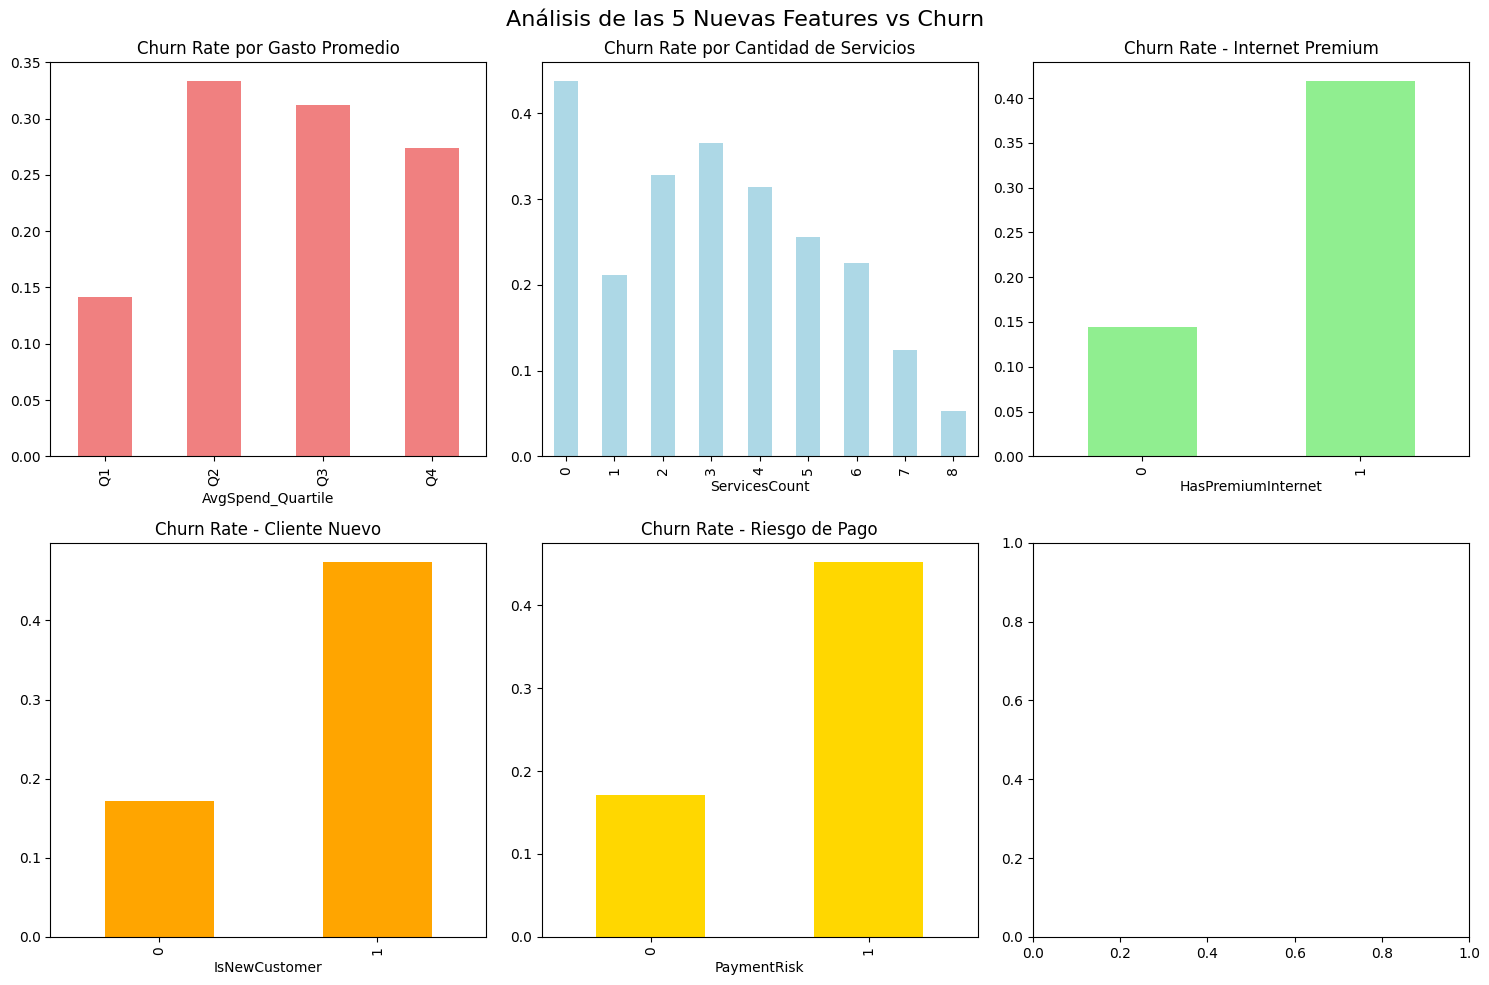

In [ ]:
# Visualización de las nuevas features
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Análisis de las 5 Nuevas Features vs Churn', fontsize=16)

# Gráficos para cada feature
df_features['AvgSpend_Quartile'] = pd.qcut(df_features['AvgMonthlySpend'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

# 1. AvgMonthlySpend
quartile_churn = df_features.groupby('AvgSpend_Quartile')['Churn'].mean()
quartile_churn.plot(kind='bar', ax=axes[0,0], color='lightcoral')
axes[0,0].set_title('Churn Rate por Gasto Promedio')

# 2. ServicesCount
services_churn = df_features.groupby('ServicesCount')['Churn'].mean()
services_churn.plot(kind='bar', ax=axes[0,1], color='lightblue')
axes[0,1].set_title('Churn Rate por Cantidad de Servicios')

# 3. HasPremiumInternet
premium_churn = df_features.groupby('HasPremiumInternet')['Churn'].mean()
premium_churn.plot(kind='bar', ax=axes[0,2], color='lightgreen')
axes[0,2].set_title('Churn Rate - Internet Premium')

# 4. IsNewCustomer
new_customer_churn = df_features.groupby('IsNewCustomer')['Churn'].mean()
new_customer_churn.plot(kind='bar', ax=axes[1,0], color='orange')
axes[1,0].set_title('Churn Rate - Cliente Nuevo')

# 5. PaymentRisk
payment_churn = df_features.groupby('PaymentRisk')['Churn'].mean()
payment_churn.plot(kind='bar', ax=axes[1,1], color='gold')
axes[1,1].set_title('Churn Rate - Riesgo de Pago')

plt.tight_layout()
plt.show()

## Regresión Logística con Pipeline y Escalado

In [ ]:
# Codificacion de variables categoricas
df_model = df_features.copy()

categorical_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
                   'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                   'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 
                   'PaperlessBilling', 'PaymentMethod']

for col in categorical_cols:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])

# Eliminar columna auxiliar si existe
if 'AvgSpend_Quartile' in df_model.columns:
    df_model = df_model.drop(columns=['AvgSpend_Quartile'])

# Separar X e y (incluyendo las 5 nuevas features)
X = df_model.drop('Churn', axis=1)
y = df_model['Churn']

print(f"Variables explicativas: {X.shape}")

Variables explicativas: (7043, 24)


In [ ]:
# División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Crear Pipeline con StandardScaler + LogisticRegression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic', LogisticRegression(random_state=42, max_iter=1000))
])

# Entrenar el modelo
pipeline.fit(X_train, y_train)

print("Modelo entrenado")

Modelo entrenado


In [ ]:
# Evaluación del modelo
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Accuracy en Training: {train_accuracy:.4f} ({train_accuracy:.1%})")
print(f"Accuracy en Test: {test_accuracy:.4f} ({test_accuracy:.1%})")

print("\nReporte de clasificación:")
print(classification_report(y_test, y_test_pred, target_names=['No Churn', 'Churn']))

Accuracy en Training: 0.8094 (80.9%)
Accuracy en Test: 0.8034 (80.3%)

Reporte de clasificación:
              precision    recall  f1-score   support

    No Churn       0.84      0.90      0.87      1035
       Churn       0.66      0.52      0.59       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.79      0.80      0.80      1409



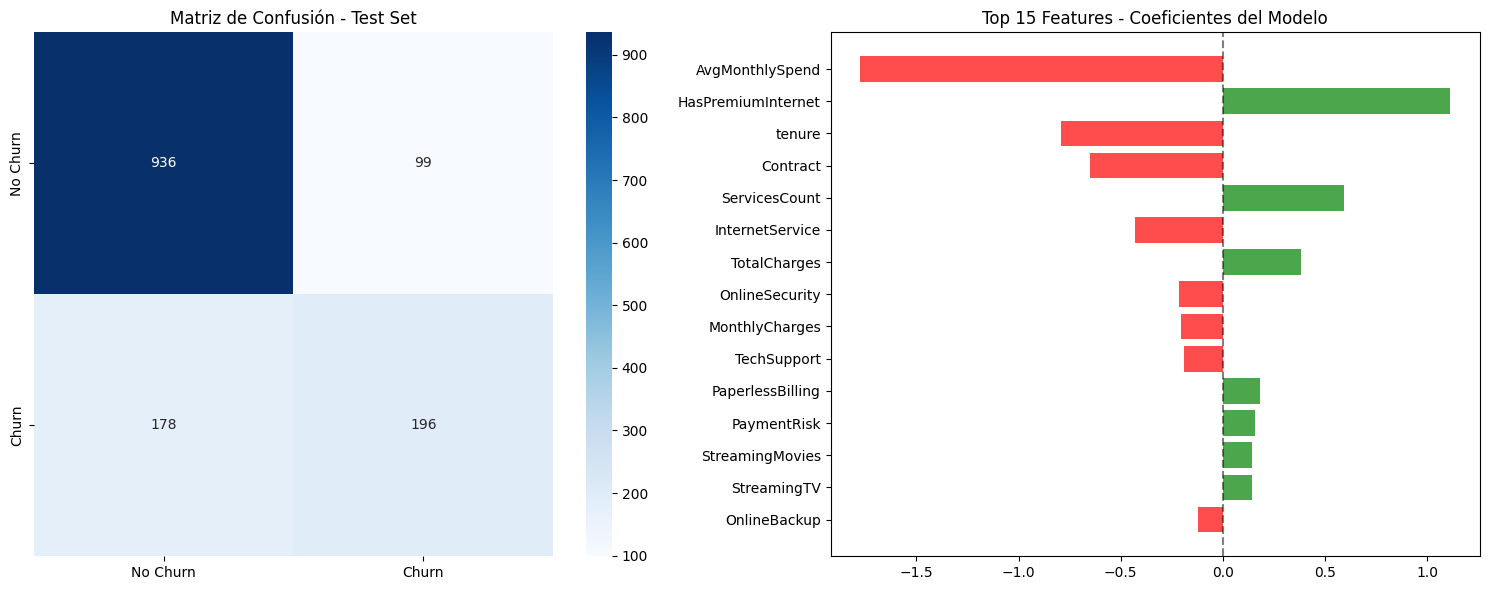

In [ ]:
# Visualización: Matriz de confusión y coeficientes
cm = confusion_matrix(y_test, y_test_pred)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No Churn', 'Churn'], 
            yticklabels=['No Churn', 'Churn'])
axes[0].set_title('Matriz de Confusión - Test Set')

# Coeficientes del modelo
coefficients = pipeline.named_steps['logistic'].coef_[0]
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values('Abs_Coefficient', ascending=True)

top_features = feature_importance.tail(15)
colors = ['red' if coef < 0 else 'green' for coef in top_features['Coefficient']]

axes[1].barh(range(len(top_features)), top_features['Coefficient'], color=colors, alpha=0.7)
axes[1].set_yticks(range(len(top_features)))
axes[1].set_yticklabels(top_features['Feature'])
axes[1].set_title('Top 15 Features - Coeficientes del Modelo')
axes[1].axvline(x=0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## Pruebas de hipotesis con statmodels (p-valores)

In [ ]:
# Agregamos constante (intercepto)
X_sm = sm.add_constant(X)

# Construir modelo statsmodels
logit_model = sm.Logit(y, X_sm)
result = logit_model.fit(disp=False)

# resumen completo
print(result.summary())

# Identificamos variables significativas
significant_vars = result.pvalues[result.pvalues < 0.05].index.tolist()
print("\nVariables significativas (p < 0.05):")
for var in significant_vars:
    if var != 'const':
        print(f"{var}")

                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 7043
Model:                          Logit   Df Residuals:                     7018
Method:                           MLE   Df Model:                           24
Date:                Sat, 27 Sep 2025   Pseudo R-squ.:                  0.2942
Time:                        21:32:10   Log-Likelihood:                -2876.3
converged:                       True   LL-Null:                       -4075.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.8524   2.55e+05   3.34e-06      1.000   -5.01e+05    5.01e+05
gender                -0.0212      0.065     -0.324      0.746      -0.150       0.107
SeniorCitizen       

## Cross Validation vs Holdout

In [ ]:
# Evaluación Holdout
y_test_pred = pipeline.predict(X_test)
y_test_proba = pipeline.predict_proba(X_test)[:,1]

holdout_accuracy = accuracy_score(y_test, y_test_pred)
holdout_auc = roc_auc_score(y_test, y_test_proba)

print(f"holdout (test 20%)")
print(f"Accuracy: {holdout_accuracy:.4f} ({holdout_accuracy:.1%})")
print(f"AUC:      {holdout_auc:.4f}")

holdout (test 20%)
Accuracy: 0.8034 (80.3%)
AUC:      0.8463


In [ ]:
# Evaluación Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Accuracy con cross_val_score
cv_accuracy = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
# AUC con cross_val_score
cv_auc = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc')

print("\nCV (5 folds)")
print(f"Accuracy medio: {cv_accuracy.mean():.4f} ({cv_accuracy.mean():.1%}) ± {cv_accuracy.std():.4f}")
print(f"AUC medio:      {cv_auc.mean():.4f} ± {cv_auc.std():.4f}")


CV (5 folds)
Accuracy medio: 0.8049 (80.5%) ± 0.0064
AUC medio:      0.8482 ± 0.0115


In [ ]:
# Comparación
print(f"Holdout -> Accuracy: {holdout_accuracy:.3f}, AUC: {holdout_auc:.3f}")
print(f"CV (5 fold) -> Accuracy: {cv_accuracy.mean():.3f}, AUC: {cv_auc.mean():.3f}")

Holdout -> Accuracy: 0.803, AUC: 0.846
CV (5 fold) -> Accuracy: 0.805, AUC: 0.848


## Métricas, Curva ROC y Ajuste de Umbral

In [ ]:
# Probabilidades de churn
y_proba = pipeline.predict_proba(X_test)[:,1]

# Métricas con umbral 0.5
y_pred_default = (y_proba >= 0.5).astype(int)

precision = precision_score(y_test, y_pred_default)
recall = recall_score(y_test, y_pred_default)
f1 = f1_score(y_test, y_pred_default)
auc = roc_auc_score(y_test, y_proba)

print(f"Default (umbral=0.5): Accuracy={accuracy_score(y_test, y_pred_default):.3f}, "
      f"Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}, AUC={auc:.3f}")

Default (umbral=0.5): Accuracy=0.803, Precision=0.664, Recall=0.524, F1=0.586, AUC=0.846


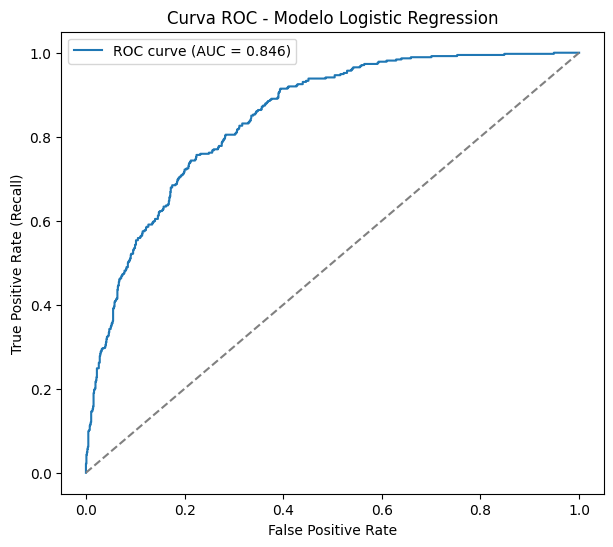

In [ ]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.3f})')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Curva ROC - Modelo Logistic Regression')
plt.legend()
plt.show()

In [ ]:
# Métricas para distintos umbrales
thresholds_to_test = [0.3, 0.4, 0.5, 0.6, 0.7]

print("\nImpacto del ajuste de umbral:")
for t in thresholds_to_test:
    y_pred_t = (y_proba >= t).astype(int)
    prec = precision_score(y_test, y_pred_t)
    rec = recall_score(y_test, y_pred_t)
    f1t = f1_score(y_test, y_pred_t)
    print(f"Umbral={t:.1f} -> Precision={prec:.3f}, Recall={rec:.3f}, F1={f1t:.3f}")


Impacto del ajuste de umbral:
Umbral=0.3 -> Precision=0.533, Recall=0.759, F1=0.626
Umbral=0.4 -> Precision=0.580, Recall=0.647, F1=0.612
Umbral=0.5 -> Precision=0.664, Recall=0.524, F1=0.586
Umbral=0.6 -> Precision=0.711, Recall=0.356, F1=0.474
Umbral=0.7 -> Precision=0.791, Recall=0.233, F1=0.360


In [ ]:
# Selección de umbral óptimo
f1_scores = []
for thr in thresholds:
    y_pred_thr = (y_proba >= thr).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_thr))

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"\nUmbral óptimo según F1-score: {best_threshold:.3f}")


Umbral óptimo según F1-score: 0.329
